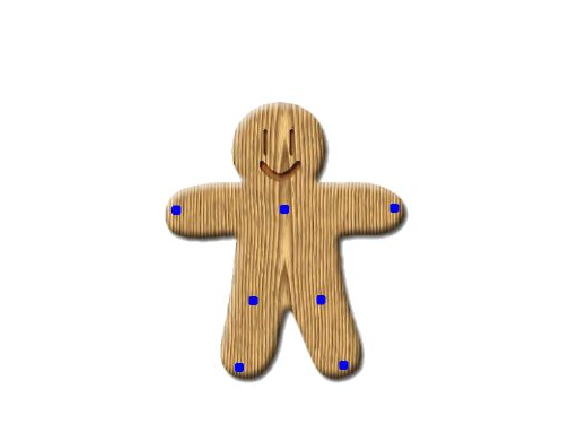

In [1]:
image = imread("math-expt/imgs/l12_toy.jpg");
rawP = [155 30; 155 125; 155 225; 235 100; 235 160; 295 85; 293 180];
rawQ = [211 42; 155 125; 100 235; 235 80; 235 140; 295 85; 295 180];

gridX = 1:size(image, 2);
gridY = 1:size(image, 1);
[Y, X] = meshgrid(gridX, gridY);

imshow(image);

In [2]:
Q = rawP;
P = rawQ;

numRow = size(X, 1);
numCol = size(X, 2);
numN = size(P, 1);

In [3]:
V = cat(3, X, Y); % [numRow, numCol, 2]
nV = repmat(reshape(V, [1, numRow, numCol, 2]), [numN, 1, 1, 1]); % [numN, numRow, numCol, 2]
nP = repmat(reshape(P, [numN, 1, 1, 2]), [1, numRow, numCol, 1]); % [numN, numRow, numCol, 2]
nQ = repmat(reshape(Q, [numN, 1, 1, 2]), [1, numRow, numCol, 1]); % [numN, numRow, numCol, 2]

In [4]:
eps = 1e-8;
alpha = 1.0;

snWeight = 1.0 / (sum((nP - nV) .^ 2, 4) + eps) .^ alpha; % [numN, numRow, numCol]
snWeight = snWeight ./ sum(snWeight, 1);
nWeight = repmat(snWeight, [1, 1, 1, 2]); % [numN, numRow, numCol, 2]

In [5]:
P_star = squeeze(sum(nP .* nWeight, 1)); % [numRow, numCol, 2]
nP_star = repmat(reshape(P_star, [1, numRow, numCol, 2]), [numN, 1, 1, 1]); % [numN, numRow, numCol, 2]
Q_star = squeeze(sum(nQ .* nWeight, 1)); % [numRow, numCol, 2]

nP_hat = nP - nP_star; % [numN, numRow, numCol, 2]
nP_hat_T = reshape(nP_hat, [numN, numRow, numCol, 1, 2]); % [numN, numRow, numCol, 1, 2]

rnP_hat = repmat(nP_hat, [1, 1, 1, 1, 2]); % [numN, numRow, numCol, 2, 2]
rnP_hat_T = repmat(nP_hat_T, [1, 1, 1, 2, 1]); % [numN, numRow, numCol, 2, 2]

nPT_W_P = nWeight .* rnP_hat .* rnP_hat_T; % [numN, numRow, numCol, 2, 2]
PT_W_P = squeeze(sum(nPT_W_P, 1)); % [numRow, numCol, 2, 2]

In [6]:
Left = (V - P_star); % [numRow, numCol, 2]
nLeft = repmat(reshape(Left, [1, numRow, numCol, 2]), [numN, 1, 1, 1]); % [numN, numRow, numCol, 2]

Inv_PT_W_P = zeros([numRow, numCol, 2, 2]);
for i = 1:numRow
    for j = 1:numCol
        subMatrix = squeeze(PT_W_P(i, j, :, :));
        Inv_PT_W_P(i, j, :, :) = inv(subMatrix);
    end
end
nInv_PT_W_P = repmat(reshape(Inv_PT_W_P, [1, numRow, numCol, 2, 2]), [numN, 1, 1, 1, 1]); % [numN, numRow, numCol, 2, 2]

nRight = nWeight .* nP_hat; % [numN, numRow, numCol, 2]

nsA = zeros([numN, numRow, numCol]);
for k = 1:numN
    for i = 1:numRow
        for j = 1:numCol
            subMatrixL = squeeze(nLeft(k, i, j, :));
            subMatrixInv = squeeze(nInv_PT_W_P(k, i, j, :, :));
            subMatrixR = squeeze(nRight(k, i, j, :, :));

            nsA(k, i, j) = subMatrixL' * subMatrixInv * subMatrixR;
        end
    end
end

In [7]:
transformed = zeros([numRow, numCol, 2]);
for k = 1:numN
    transformed = transformed + squeeze(nsA(k, :, :, :)) .* (squeeze(nQ(k, :, :, :)) - Q_star);
end

transformed = transformed + Q_star;

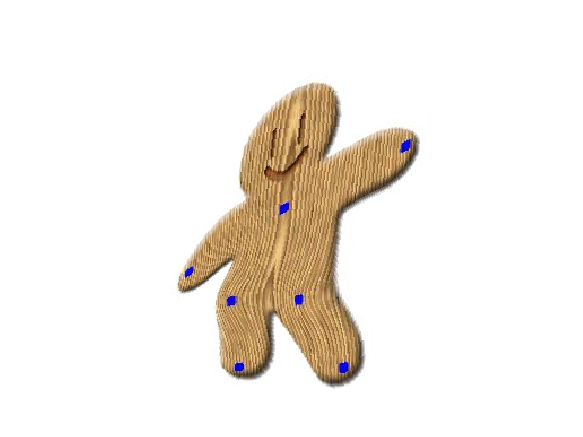

In [15]:
affine_deformed = zeros(size(image));

for i = 1:numRow
    for j = 1:numCol
        x = transformed(i, j, 2);
        y = transformed(i, j, 1);
        if x >= 1 && x <= numCol && y >= 1 && y <= numRow
            affine_deformed(i, j, :) = image(round(y), round(x), :);
        else
            affine_deformed(i, j, :) = 255;
        end
    end
end

imshow(affine_deformed / 255);